# CS-671, Fall 2025 - HW 1, Q2

# Q2 Part 1: Is accuracy or F1 score a more appropriate performance metric to use for this task? Why?

F1 score is more appropriate because the classes are imbalanced. Accuracy alone may give an inaccurate estimate to how good a model's performance is, whereas the F1 score provides a more reliable evaluation by focusing on both the performance of the majority and minority class.

## StarterCode Setup

### Importing Libraries

In [2]:
import numpy as np
from numpy.linalg import norm
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

### Loading Dataset, Splitting Data into Train and Test sets

In [3]:
bcd = load_breast_cancer()
X = bcd.data
y = bcd.target
y = 1 - y

# Split the dataset with a fixed random seed (random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(455, 30) (114, 30) (455,) (114,)


## Q2 (b): Implement a k-NN algorithm from scratch to classify the dataset. Use `k = 31` and the `euclidean` distance, and __make sure to normalize the data__. Report your model’s F1 score on the test set.

In [16]:
eps = 1e-12
Xtr_min = X_train.min(axis=0)
Xtr_max = X_train.max(axis=0)

X_train_norm = (X_train - Xtr_min) / (Xtr_max - Xtr_min + eps)
X_test_norm  = (X_test  - Xtr_min) / (Xtr_max - Xtr_min + eps)

In [17]:
# euclidean distance
def euclidean_distance(x1, x2):
    ret = 0
    for i in range(len(x1)):
        ret += (x1[i]-x2[i]) ** 2
    return np.sqrt(ret)

def cosine_similarity(x1, x2):
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

def knn_predict(X_train, y_train, X_test, k, dist_func):
    predictions = []
    for x in X_test:
        if dist_func == 'euclidean':
            distances = [euclidean_distance(x, x_train) for x_train in X_train]
        elif dist_func == 'cosine':
            distances = [cosine_similarity(x, x_train) for x_train in X_train]
        else:
            raise ValueError("Invalid distance function")
        k_nearest = np.argsort(distances)[:k]
        k_nearest_labels = [y_train[i] for i in k_nearest]
        predictions.append(np.argmax(np.bincount(k_nearest_labels)))
    return predictions

In [18]:
predictions = knn_predict(X_train_norm, y_train, X_test_norm, 31, 'euclidean')

In [19]:
def f1_score(y_true, y_pred):
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            tp += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            fn += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            fp += 1
    
    # Handle edge cases to avoid division by zero
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    if precision + recall == 0:
        return 0
    else:
        return 2 * precision * recall / (precision + recall)

f1_score(y_test, predictions)

0.9090909090909091

## Q2 (c): Use cross-validation with 5 folds and the F1 score to tune the value of k and the distance function used (possible distance functions to use could be Euclidean distance, Manhattan distance, or cosine similarity). Make sure to use at least five values of k between 1 and 63, and try at least two distance functions. For each distance function, show a plot where the x-axis depicts the value of k and the y-axis depicts the average F1 score for that value of k during cross-validation. Which pair of parameters performed the best? Note: You may find the array split method from NumPy helpful when implementing cross-validation.

In [ ]:
ks = [2, 5, 8, 15, 22, 30, 38, 45, 52, 63]

# Returns the average f1 score for given k and distance function
def cross_validation(X, y, k, dist_func):
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    performance = 0

    for i in range(k):
        X_train = np.concatenate(X_folds[:i] + X_folds[i+1:])
        y_train = np.concatenate(y_folds[:i] + y_folds[i+1:])
        X_test = X_folds[i]
        y_test = y_folds[i]
        
        # Per-fold per-feature min-max using only fold-train stats
        Xtr_min = X_train.min(axis=0)
        Xtr_max = X_train.max(axis=0)
        norm_X_train = (X_train - Xtr_min) / (Xtr_max - Xtr_min + 1e-12)
        norm_X_test  = (X_test  - Xtr_min) / (Xtr_max - Xtr_min + 1e-12)

        predictions = knn_predict(norm_X_train, y_train, norm_X_test, k, dist_func)

        loss = f1_score(y_test, predictions)
        performance += loss

    return performance / k


# Plot Euclidean Distance

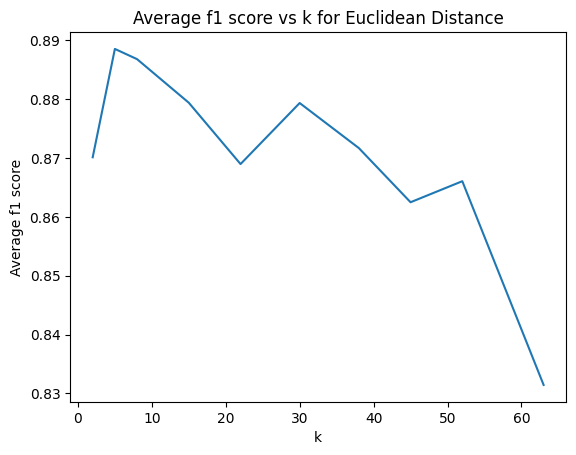

In [14]:
f1s = []
for k in ks:
    f1s.append(cross_validation(X_train_norm, y_train, k, 'euclidean'))

plt.plot(ks, f1s)
plt.xlabel('k')
plt.ylabel('Average f1 score')
plt.title('Average f1 score vs k for Euclidean Distance')
plt.show()

# Plot Cosine Similarity

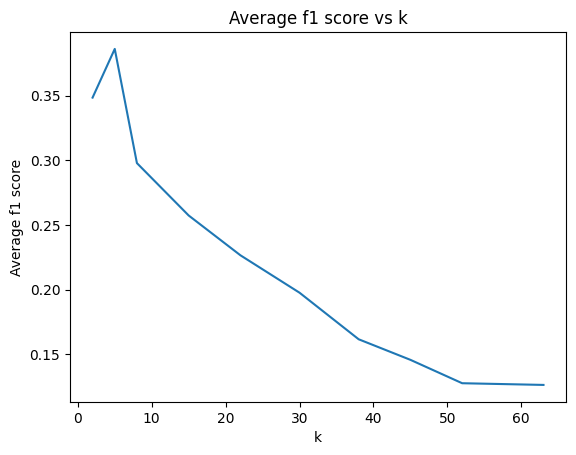

In [15]:
f1s = []
for k in ks:
    f1s.append(cross_validation(X_train_norm, y_train, k, 'cosine'))

plt.plot(ks, f1s)
plt.xlabel('k')
plt.ylabel('Average f1 score')
plt.title('Average f1 score vs k')
plt.show()

The best performance came from k=5 and using Euclidean Distance.

## Q2 (d): Using the best parameters determined in part (c), report the performance of a k-NN classifier on the test set. Compare this to your model in part (b). Is it as you expected?

In [77]:
best_preds = knn_predict(X_train_norm, Y_train_norm, X_test_norm, 5, 'euclidean')

print(f1_score(best_preds, y_test))

0.88


Yes, this is as I expected. Since we tuned the parameters to perform best on this training set specifically, I would assume the F1 score on the test data to be higher than the untuned version.

## Q2 (e -> i): Using the test dataset and the same parameters as part (c), plot the ROC curve of your classifier as points connected by lines. You may implement the ROC curve computation using either of the two methods discussed in the HW PDF

In [78]:
def tpr(y_true, y_pred):
    tp = 0
    fn = 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            tp += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            fn += 1
    
    if tp + fn == 0:  # No positive true labels
        return 0
    else:
        return tp / (tp + fn)

def fpr(y_true, y_pred):
    fp = 0
    tn = 0
    for i in range(len(y_true)):
        if y_true[i] == 0 and y_pred[i] == 1:
            fp += 1
        if y_true[i] == 0 and y_pred[i] == 0:
            tn += 1
    
    if fp + tn == 0:  # No negative true labels
        return 0
    else:
        return fp / (fp + tn)

In [79]:
# Modified k-NN function that returns probabilities instead of hard predictions
def knn_predict_proba(X_train, y_train, X_test, k, dist_func):
    probabilities = []
    for x in X_test:
        if dist_func == 'euclidean':
            distances = [euclidean_distance(x, x_train) for x_train in X_train]
        elif dist_func == 'cosine':
            distances = [cosine_similarity(x, x_train) for x_train in X_train]
        else:
            raise ValueError("Invalid distance function")
        
        # Get k nearest neighbors
        k_nearest_indices = np.argsort(distances)[:k]
        k_nearest_labels = [y_train[i] for i in k_nearest_indices]
        
        # Calculate probability of class 1
        prob_class_1 = sum(k_nearest_labels) / k
        probabilities.append(prob_class_1)
    
    return probabilities

# Generate ROC curve points
def generate_roc_curve(y_true, probabilities):
    # Sort probabilities and get unique thresholds
    sorted_probs = sorted(set(probabilities))
    roc_points = []
    
    # Add endpoints
    roc_points.append((1.0, 1.0))  # (FPR, TPR) when threshold = 0
    
    for threshold in sorted_probs:
        # Convert probabilities to binary predictions using threshold
        y_pred = [1 if prob >= threshold else 0 for prob in probabilities]
        
        # Calculate TPR and FPR
        tpr_val = tpr(y_true, y_pred)
        fpr_val = fpr(y_true, y_pred)
        
        roc_points.append((fpr_val, tpr_val))
    
    # Add point (0, 0) when threshold = 1
    roc_points.append((0.0, 0.0))
    
    # Sort by FPR
    roc_points.sort()
    
    return roc_points


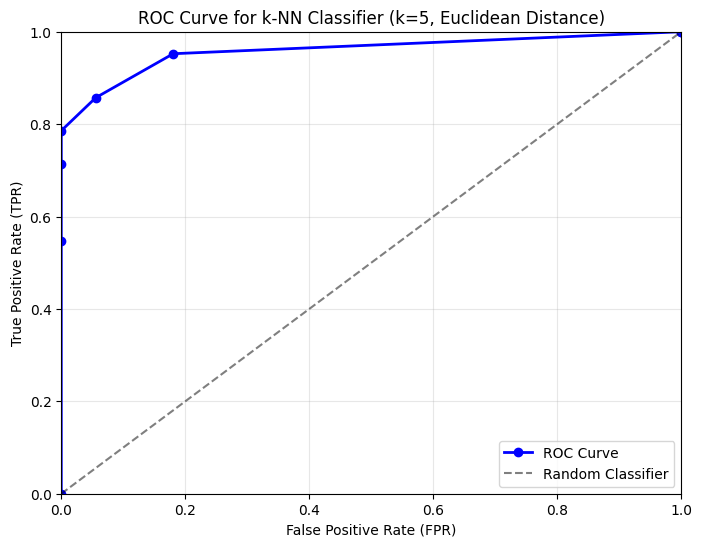

AUC Score: 0.9587


In [ ]:
# Generate probabilities using best parameters (k=5, euclidean distance)
probabilities = knn_predict_proba(X_train_norm, y_train, X_test_norm, 5, 'euclidean')

# Generate ROC curve points
roc_points = generate_roc_curve(y_test, probabilities)

# Extract FPR and TPR values for plotting
fpr_values = [point[0] for point in roc_points]
tpr_values = [point[1] for point in roc_points]

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, 'bo-', linewidth=2, markersize=6, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for k-NN Classifier (k=5, Euclidean Distance)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


### Q2 (e -> ii)

In [1]:
# Calculate and print AUC (Area Under Curve)
def calculate_auc(fpr_values, tpr_values):
    auc = 0
    for i in range(1, len(fpr_values)):
        auc += (fpr_values[i] - fpr_values[i-1]) * (tpr_values[i] + tpr_values[i-1]) / 2
    return auc

auc_score = calculate_auc(fpr_values, tpr_values)
print(f"AUC Score: {auc_score:.4f}")

NameError: name 'fpr_values' is not defined